In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np 

mpl.rcParams['figure.dpi'] = 100

In [6]:
from utils.corpus import Corpus

corpus = Corpus(registry_path='utils/article_registry.json')
corpus_list = corpus.get_documents_list()

Loading corpus. Num. of articles: 906


In [7]:
# Hacky hack hack: el último parsing de pdfs no está guardando el formato por algún motivo.
for c in corpus.documents:
    if hasattr(c, 'unknown_words_start'):
        c.format = "pdf"

corpus.save_documents()

In [8]:
data = []
for article in corpus.load_documents_from_registry(only_articles=False):
    data.append(article.__dict__)

df = pd.DataFrame(data)
df = df[['id', 'format', 'lang', 'date', 'type', 'clean_text', 'bag_of_words', 'unknown_words_start', 'unknown_words_end']]
df['date'] = df['date'].apply(lambda x: int(x[:4]))

In [9]:
df.head()

,id,format,lang,date,type,clean_text,bag_of_words,unknown_words_start,unknown_words_end
0,54933,html,es,2017,ARTÍCULOS,XML \t Recibido: de febrero de ;...,xml recibido febrero aceptado abril resumir ar...,NaN,NaN
1,28952,pdf,es,1967,CRONICAS Y COMENTARIOS,NaN,NaN,46.0,1.0
2,21681,pdf,es,1964,REVISTA DE LIBROS,NaN,NaN,NaN,NaN
3,29183,pdf,es,1984,ARTÍCULOS,LOUISDUPRE enigma delante RELIGIOSO · Para San...,louisdupre enigma religioso santayana arte rel...,435.0,33.0
4,29527,pdf,es,1952,INFORMACIÓN,NaN,NaN,402.0,28.0


## Article types

In [10]:
most_common_types = df.groupby(['type']).count()['id'].sort_values(ascending=False)[:5]
most_common_types

type
ARTÍCULOS                    906
RESEÑAS                      279
DIÁLOGOS                     129
TRADUCCIONES                  39
COMENTARIOS Y DISCUSIONES     29
Name: id, dtype: int64

<AxesSubplot:xlabel='id', ylabel='type'>

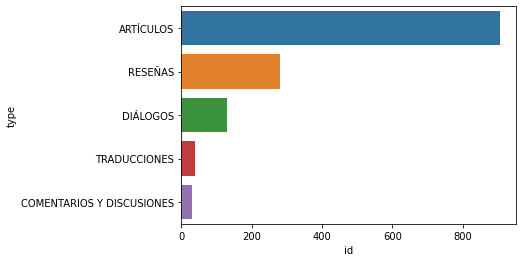

In [11]:
sns.barplot(x = most_common_types, y = most_common_types.index)

In [12]:
year_type_counts = df[df['type'].isin(most_common_types.index)].groupby(['date', 'type']).count()['id'].reset_index()

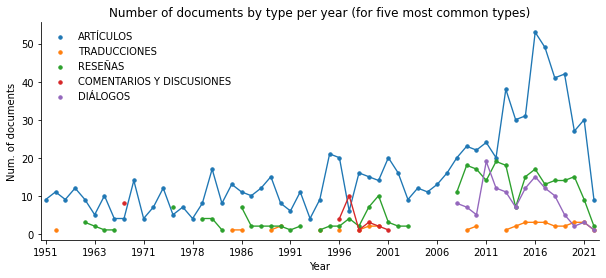

In [13]:
plt.figure(figsize = (10, 4))
sns.pointplot(data = year_type_counts, x = 'date', y = 'id', hue = 'type', scale = 0.5)
ticks, labels = plt.xticks()
plt.ylabel('Num. of documents')
plt.xlabel('Year')
plt.title("Number of documents by type per year (for five most common types)")
plt.xticks(ticks[::5], labels[::5])
plt.legend(frameon=False)
sns.despine()

## Orthographic correction

In [14]:
correction_df = df[['unknown_words_start', 'unknown_words_end']].melt()
correction_df.groupby('variable').describe()

value                                                     \
                     count        mean         std  min    25%    50%     75%   
variable                                                                        
unknown_words_end    770.0   74.563636  214.707408  0.0    8.0   20.0   46.00   
unknown_words_start  770.0  306.681818  355.037797  0.0  105.0  187.5  388.75   

                             
                        max  
variable                     
unknown_words_end    2328.0  
unknown_words_start  3514.0

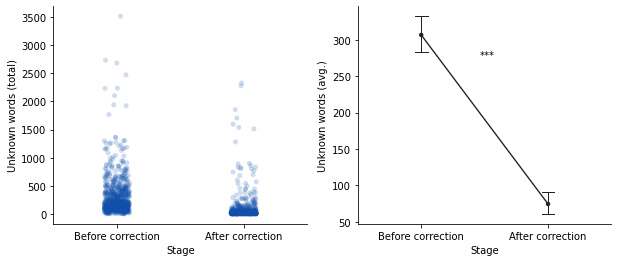

In [15]:
fig, axs = plt.subplots(1, 2)

fig.set_figwidth(10)

sns.stripplot(data = correction_df, x = 'variable', y = 'value', alpha = 0.2, color="#1050aa", ax=axs[0])
axs[0].set_ylabel('Unknown words (total)')

sns.pointplot(data = correction_df, x = 'variable', y = 'value', color="#222", scale=0.5, errwidth=1, capsize=0.1)
axs[1].set_ylabel('Unknown words (avg.)')
axs[1].text(0.46, 275, "***")

for ax in axs:
    ax.set_xticklabels(["Before correction", "After correction"])
    ax.set_xlabel('Stage')
sns.despine()

In [29]:
from scipy.stats import ttest_rel

In [31]:
orthographic_df = df[['unknown_words_start', 'unknown_words_end']].dropna()

stat, pvalue = ttest_rel(orthographic_df['unknown_words_start'], orthographic_df['unknown_words_end'], alternative='greater')
d = (orthographic_df['unknown_words_start'].mean() - orthographic_df['unknown_words_end'].mean()) / np.mean([orthographic_df['unknown_words_start'].std(), orthographic_df['unknown_words_end'].std()])

print(f"T-test results: t={stat:.3f}, p<{pvalue:.3f}")
print(f"Effect size (Cohen's d): {d:.3f}")

T-test results: t=30.523, p<0.000
Effect size (Cohen's d): 0.815


### How successful is orthographic correction depending on the year of publication?

In [32]:
correction_by_year = df[['date', 'unknown_words_start', 'unknown_words_end']].melt(['date'])
correction_by_year.head()

,date,variable,value
0,2017,unknown_words_start,NaN
1,1967,unknown_words_start,46.0
2,1964,unknown_words_start,NaN
3,1984,unknown_words_start,435.0
4,1952,unknown_words_start,402.0


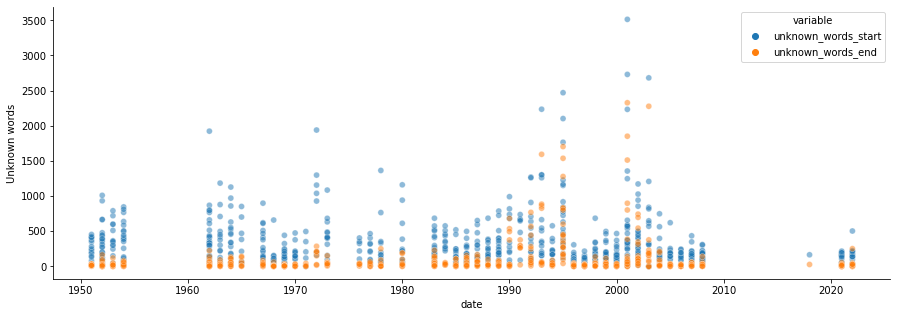

In [33]:
plt.figure(figsize = (15, 5))
sns.scatterplot(data = correction_by_year, x = 'date', y = 'value', hue='variable', alpha = 0.5)
plt.ylabel('Unknown words')
sns.despine()

## Word counts

In [34]:
df['word count'] = df['clean_text'].apply(lambda x: len(x.split()) if isinstance(x, str) else x)
df[['date', 'word count']].describe()

,date,word count
count,1641.000000,906.000000
mean,2000.057282,9333.788079
std,19.590886,4119.249902
min,1951.000000,211.000000
25%,1988.000000,6772.500000
50%,2009.000000,8984.000000
75%,2016.000000,11113.750000
max,2022.000000,36047.000000


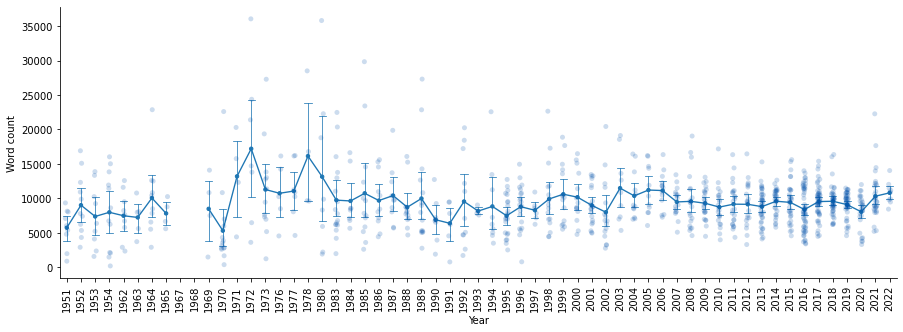

In [35]:
plt.figure(figsize=(15,5))
sns.stripplot(data = df, x = 'date', y = 'word count', alpha = 0.2, color="#0050aa")
sns.pointplot(data = df, x = 'date', y = 'word count', capsize=0.5, scale=0.5, errwidth=0.75)
plt.ylabel("Word count")
plt.xlabel("Year")
plt.xticks(rotation = 90)
sns.despine()

In [36]:
df['bow_w_count'] = df['bag_of_words'].apply(lambda x: len(x.split()) if isinstance(x, str) else np.nan)

Text(0, 0.5, 'Num. of words')

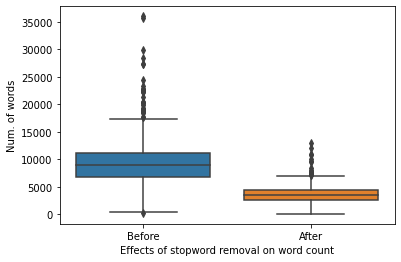

In [37]:
ax = sns.boxplot(data = df[['word count', 'bow_w_count']].melt(), x = 'variable', y = 'value')
ax.set_xticklabels(['Before', 'After'])
ax.set_xlabel('Effects of stopword removal on word count')
ax.set_ylabel('Num. of words')

## Articles per year

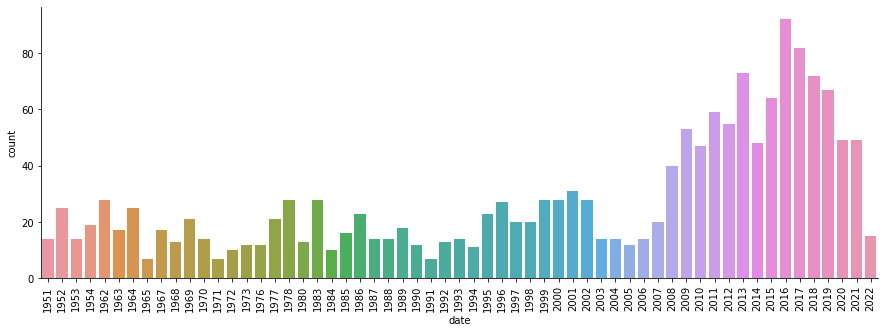

In [38]:
plt.figure(figsize = (15, 5))
sns.countplot(data = df, x = 'date')
plt.xticks(rotation=90)
sns.despine()

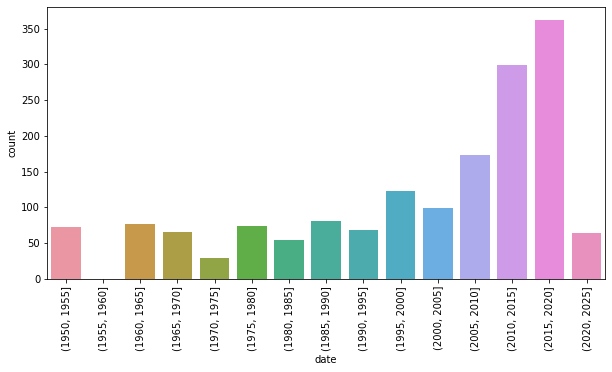

In [43]:
x = pd.cut(df['date'], bins = [x for x in range(1950, 2026, 5)])
y = df['word count']

plt.figure(figsize = (10, 5))
sns.countplot(x = x)
_ = plt.xticks(rotation = 90)

---

# Topic analysis

In [8]:
years = []
for topic in range(90):
    years +=[{'topic': topic, 'year': article[0].year, 'id':article[0].id} for article in get_articles_in_topic(topic, min_prob=0.5)]

In [9]:
df = pd.DataFrame(years)

In [10]:
df['year'] = df['year'].astype(int)
df['year'] = pd.cut(df['year'], bins = [x for x in range(1950, 2021, 5)])


In [11]:
yearProgression = df.groupby(['year', 'topic']).count().unstack()
yearProgression.fillna(0, inplace = True)

In [12]:
yearProgression.columns = [index[1] for index in yearProgression.columns]

In [13]:
yearProgression = yearProgression[yearProgression.columns[yearProgression.sum()>=10]]

In [14]:
#per = yearProgression.apply(lambda x: x / x.sum() * 100, axis = 1).fillna(0)
per = yearProgression

per['end'] = [x.right for x in per.index]

per.set_index('end', inplace = True)

per = per[per.index > 1970]

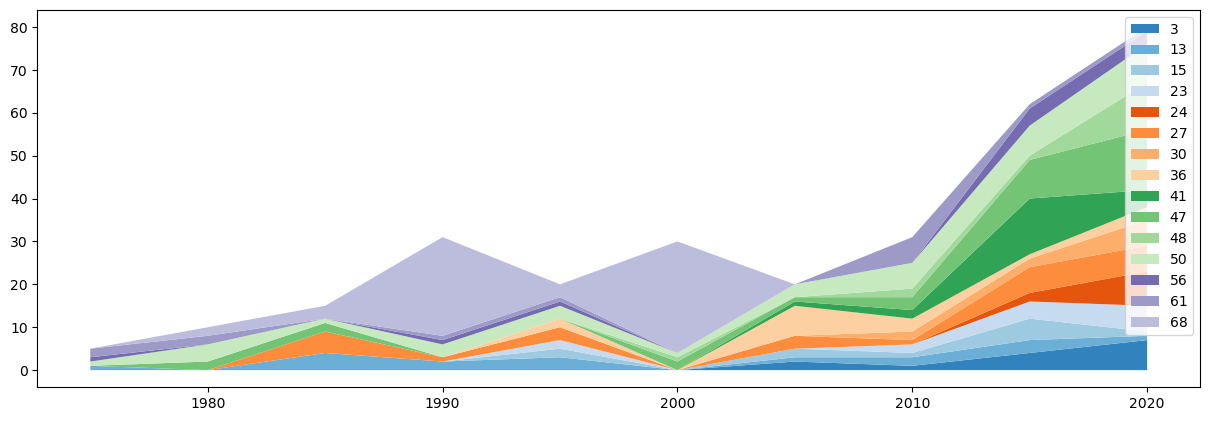

In [15]:
fig = plt.figure(figsize=(15,5))

from cycler import cycler 

colors = plt.cm.tab20c.colors

plt.gca().set_prop_cycle(cycler('color', colors))

base = 0
c = 0.01
for topic in per.iteritems():
    data = topic[1]
    
    plt.fill_between(per.index, y1 = base, y2 = base + data, label = topic[0])
    
    base += data
    c += 0.08
    
plt.legend()

---